In [65]:
%%capture 
!pip install h2o==3.38.0.4
!pip install teemi

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 11_2_LEARN_Modelling_and_predictions

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/teemi/blob/main/colab_notebooks/11_2_LEARN_Modelling_and_predictions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repository like this: 

In [67]:
# cloning the data repo
!git clone https://github.com/hiyama341/G8H_CPR_library.git

fatal: destination path 'G8H_CPR_library' already exists and is not an empty directory.


## 0. Intro

This is the second notebook showcasing how we can use machine learning techniques to predict the best promoter-gene combinations. We will use various machine learning algorithms through the package H2O. We continue the workflow by using Machine Learning to predict the best promoter:gene combinations of the remaining library that was generated in [09_2_BUILD_CombinatorialLibrary](../colab_notebooks/09_2_BUILD_CombinatorialLibrary.ipynb) and analyzed in [10_2_TEST_Library_Characterization](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb). 

What is different in this notebook is that we investigate how the ML faired in predicting strictosidine values and we compare how a ML model trained on two rounds of data differ from the one we used in notebook [07_1_LEARN_DataAnalysis](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb)


## Project overview - Use ML to predicte best promoter:gene combinations 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

**2nd library**

Tasks
1. dgRNA
2. Base strain
3. Library
4. Phenotyping
**5. Machine Learning**
   - Predict the best promoter:gene combinations


## 1. Setup H2O AutoML

In [68]:
import h2o
from h2o.automl import H2OAutoML

In [69]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 31 mins
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,5 months and 4 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_pfx5z2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.593 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [70]:
first_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0.922793
1,yp49_C01,1,2,5,9,0.149626,0.509123
2,yp49_D01,2,4,7,3,0.049042,0.166871
3,yp49_E01,2,1,5,7,0.096246,0.327489
4,yp49_F01,3,3,6,1,7.365141,25.060934
...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000,0.000000
163,yp51_D12,8,2,7,6,0.202343,0.591185
164,yp51_E12,8,1,6,10,0.153556,0.448644
165,yp50_F05,6,1,8,2,4.656777,13.391244


### 1.2 Investigate how the predictions from the previous ML cycle matched the sampled strains 

In [71]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp53_A01,4,1,5,2,2.546823,9.058562
1,yp53_A02,4,1,5,2,7.921696,28.175952
2,yp53_A04,4,2,5,2,22.597750,80.375862
3,yp53_A06,5,1,5,2,34.235068,121.767572
4,yp53_A07,5,2,6,2,44.719792,159.059724
...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15.322951
125,yp54_C04,5,2,6,3,26.634041,94.318358
126,yp54_C09,3,1,6,3,13.122270,46.469517
127,yp54_D12,5,1,6,6,1.049920,3.718051


In [72]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 


g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,G8H,pG8H,pCPR,CPR
0,yp53_A01,4,1,5,2,2.546823,9.058562,Vmin,CYC1,CCW12,Aan
1,yp53_A02,4,1,5,2,7.921696,28.175952,Vmin,CYC1,CCW12,Aan
2,yp53_A04,4,2,5,2,22.597750,80.375862,Vmin,ENO2,CCW12,Aan
3,yp53_A06,5,1,5,2,34.235068,121.767572,Smus,CYC1,CCW12,Aan
4,yp53_A07,5,2,6,2,44.719792,159.059724,Smus,ENO2,TPI1,Aan
...,...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15.322951,Vmin,CYC1,TPI1,Cro
125,yp54_C04,5,2,6,3,26.634041,94.318358,Smus,ENO2,TPI1,Ara
126,yp54_C09,3,1,6,3,13.122270,46.469517,Cro,CYC1,TPI1,Ara
127,yp54_D12,5,1,6,6,1.049920,3.718051,Smus,CYC1,TPI1,Ahu


In [73]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'Amt_norm', 'Line_name']]
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [74]:
first_round_top_producers = pd.read_csv('G8H_CPR_library/data/09-AutoML/Top20_predictions/first_round/top20_ML_predicted_after_first_DBTL_1st_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

# add names columns
first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct
0,Smus-ENO2-TPI1-Rse,169.288180,1.000000
1,Rsep-ENO2-TPI1-Ara,162.151856,0.999106
2,Smus-ENO2-CCW12-Ara,161.904255,0.998213
3,Smus-CYC1-TPI1-Ara,157.638727,0.997319
4,Smus-ENO2-TPI1-Aan,156.976470,0.996425
...,...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477,0.004468
1115,Ccal-ENO2-TPI1-Cac,-12.768510,0.003575
1116,Rsep-PCK1-CCW12-Ara,-12.901417,0.002681
1117,Ccal-ENO2-CCW12-Cac,-16.241411,0.001787


In [75]:
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [76]:
## merging the unsampled library with the second sampling
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['Amt_norm'].rank(pct=True)
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank(pct=True)

predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'Amt_norm', ascending = False)

In [77]:
predicted_vs_sampled

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct,Amt_norm,Line_name,norm_strict_measured_rank
0,Smus-ENO2-TPI1-Rse,169.288180,0.995575,169.631396,yp53_D09,1.000000
10,Rsep-ENO2-TPI1-Clo,103.496648,0.907080,159.517718,yp53_C06,0.991150
4,Smus-ENO2-TPI1-Aan,156.976470,0.964602,159.059724,yp53_A07,0.982301
31,Smus-CYC1-CCW12-Clo,57.162466,0.725664,143.483630,yp53_C01,0.973451
32,Cro-ENO2-TPI1-Cro,56.438602,0.712389,138.267757,yp54_B01,0.964602
...,...,...,...,...,...,...
99,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D10,0.061947
98,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D09,0.061947
97,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G04,0.061947
96,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G03,0.061947


In [78]:
from teemi.learn.plotting import correlation_plot

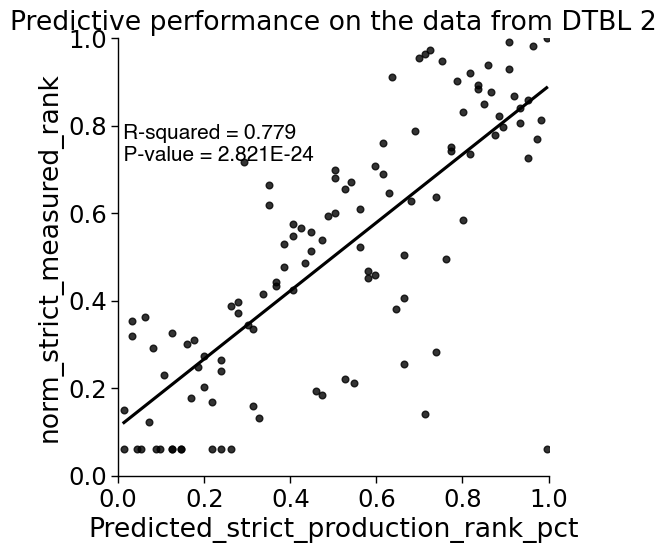

In [79]:
correlation_plot(predicted_vs_sampled,"Predicted_strict_production_rank_pct","norm_strict_measured_rank",
                 title = 'Predictive performance on the data from DTBL 2',
                 size_height= 5, size_length = 5)

### 1.3 Concatting the dataframes for updating the model 

In [80]:
first_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
second_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')

We can add the first dataframe to the second. See below: 

In [81]:
new_input_for_ml = pd.concat([first_input_for_ml, second_input_for_ml])
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0.922793
1,yp49_C01,1,2,5,9,0.149626,0.509123
2,yp49_D01,2,4,7,3,0.049042,0.166871
3,yp49_E01,2,1,5,7,0.096246,0.327489
4,yp49_F01,3,3,6,1,7.365141,25.060934
...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15.322951
125,yp54_C04,5,2,6,3,26.634041,94.318358
126,yp54_C09,3,1,6,3,13.122270,46.469517
127,yp54_D12,5,1,6,6,1.049920,3.718051


### 1.4 Update dataframe Change 

In [82]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:296
Cols:7

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
type,string,int,int,int,int,real,real
mins,NaN,1.0,1.0,5.0,1.0,0.0,0.0
mean,NaN,4.773648648648647,2.1452702702702697,6.135135135135138,4.750000000000003,8.425198588094599,28.172298324091862
maxs,NaN,8.0,4.0,8.0,10.0,85.21014946,245.03427469317091
sigma,NaN,1.946604570553522,1.115003045338059,1.0554051268004114,2.5930153901508803,13.47666920488858,44.45848009052247
zeros,0,0,0,0,0,72,72
missing,0,0,0,0,0,0,0
0,yp49_A01,1.0,2.0,5.0,1.0,0.271198899,0.9227925961906795
1,yp49_C01,1.0,2.0,5.0,9.0,0.149625874,0.5091231905250453
2,yp49_D01,2.0,4.0,7.0,3.0,0.049041597,0.166870967337397


In [83]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [84]:
df_test.describe()

Rows:296
Cols:7

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
type,string,enum,enum,enum,enum,real,real
mins,NaN,,,,,0.0,0.0
mean,NaN,,,,,8.425198588094599,28.172298324091862
maxs,NaN,,,,,85.21014946,245.03427469317091
sigma,NaN,,,,,13.47666920488858,44.45848009052247
zeros,0,,,,,72,72
missing,0,0,0,0,0,0,0
0,yp49_A01,1,2,5,1,0.271198899,0.9227925961906795
1,yp49_C01,1,2,5,9,0.149625874,0.5091231905250453
2,yp49_D01,2,4,7,3,0.049041597,0.166870967337397


### 1.5 If you dont want to run the AutoML skip the following paragraphs and go to paragraph 4.

## 2. RUN automl

In [85]:
# Set the following to true if you want to run AUTOML
auto_ml = False

Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


Here we are defining the autoML object and after we can train it

In [86]:
if auto_ml: 
    # Select the columns we want to train on
    feature_cols = ['0', '1', '2', '3']

    # Initialize H2O autoML class
    AutoML = H2OAutoML(
        max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
        max_models=None,  # None =  no limit
        nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
        seed=1,            # Reproducibility
        sort_metric = "MAE",
        keep_cross_validation_predictions=True)

Train a model based on the target and the df. 

In [87]:
#%%time
if auto_ml: 

    AutoML.train(
         x=feature_cols,
         y='Amt_norm',
         training_frame=df_test,
     )

In [88]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model . i.e. saving the best model and the leaderboard. 


In [89]:
if auto_ml: 
    ## Saving the leaderboard ids
    leaderboard = AutoML.leaderboard
    model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])
   

In [90]:
if auto_ml: 
    ## how to save any model
    out_path = 'G8H_CPR_library/data/09-AutoML/best_models/second_round/'
    mdl = h2o.get_model(model_ids[1])
    h2o.save_model(model=mdl, path=out_path, force=True)

Now we want to extract the best models

In [91]:
if auto_ml: 
    df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
    df_from_h2o_object

### 3.1 Saving the best model

In [92]:
if auto_ml: 
    best_model = AutoML.get_best_model()
    model_path = h2o.save_model(model=best_model, path="G8H_CPR_library/data/09-AutoML/best_models/second_round/", force=True)
    best_model

### 3.2 Exporting the leaderboard

In [93]:
if auto_ml: 
    # saving the leaderboard
    out_path = 'G8H_CPR_library/data/09-AutoML/leaderboards/second_round/'
    h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

### 3.3 saving the CV-holdout predictions 


In [94]:
if auto_ml:     
    # Get the predictions
    cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
    
    # make the df_test to a dataframe
    as_data_frame_df_test = df_test.as_data_frame()
    
    # Make cv_pred to a dataframe
    as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()
    as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
    as_data_frame_CV_predictions

In [95]:
if auto_ml: 
    # merge with the test dataframe
    df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
    df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
    df3 = df3.reset_index()
    df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
    df3['cv_holdout_predictions_ranked_pct'] = df3['cv_holdout_predictions'].rank(pct= True)
    # save it to the folder
    df3.to_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')
    df3

## 4. Importing the best model 

If you didnt have time to run the model you can start from here and import it. 

Start by importing the leaderboard

In [96]:
leaderboard_path = 'G8H_CPR_library/data/09-AutoML/leaderboards/second_round/'
lb = h2o.import_file(path=os.path.join(leaderboard_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3,11.9288,23.3401,544.76,nan,544.76
StackedEnsemble_BestOfFamily_7_AutoML_2_20230201_153113,12.0041,23.2071,538.568,nan,538.568
StackedEnsemble_BestOfFamily_5_AutoML_2_20230201_153113,12.0682,23.1038,533.783,nan,533.783
XGBoost_grid_1_AutoML_2_20230201_153113_model_165,12.2021,23.8091,566.874,nan,566.874
StackedEnsemble_BestOfFamily_4_AutoML_2_20230201_153113,12.311,24.0141,576.676,nan,576.676
StackedEnsemble_AllModels_5_AutoML_2_20230201_153113,12.4988,23.2079,538.608,nan,538.608
XGBoost_grid_1_AutoML_2_20230201_153113_model_131,12.5229,23.5701,555.55,nan,555.55
StackedEnsemble_AllModels_6_AutoML_2_20230201_153113,12.6098,23.4335,549.13,nan,549.13
StackedEnsemble_BestOfFamily_6_AutoML_2_20230201_153113,12.8598,24.1369,582.589,0.963671,582.589
StackedEnsemble_Best1000_1_AutoML_2_20230201_153113,13.3572,23.8771,570.116,nan,570.116


Then the best model. So the following is usefull if you want to try and use the other models(and you have saved them). Alternatively, you can also use the model we have saved and was trained in this work namely: 'XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3'

In [97]:
best_model = h2o.load_model("G8H_CPR_library/data/09-AutoML/best_models/second_round/"+lb[0,0])
best_model

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_2_20230201_153113_select_grid_model_3


Model Summary: 
    number_of_trees
--  -----------------
    160

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 362.72693937301756
RMSE: 19.04539155210566
MAE: 8.669277115850836
RMSLE: NaN
Mean Residual Deviance: 362.72693937301756

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 544.7599421212705
RMSE: 23.340093018693615
MAE: 11.928834673923415
RMSLE: NaN
Mean Residual Deviance: 544.7599421212705

Cross-Validation Metrics Summary: 
                        mean      sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  --------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     11.917    2.39606   14.5257       11.5357       12.51         14.8639       7.40361       14.1791       12.7468       9.01759       11.3582       11.029
mean_residual_deviance  544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
mse                     544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
r2                      0.682581  0.173342  0.554383      0.831341      0.721576      0.65435       0.906327      0.754315      0.742156      0.562592      0.303511      0.795258
residual_deviance       544.723   234.855   622.094       397.664       487.356       1086.95       169.938       515.316       644.754       475.67        608.954       438.538
rmse                    22.8485   5.0187    24.9418       19.9415       22.0761       32.9689       13.036        22.7006       25.392        21.8099       24.677        20.9413
rmsle                   0.967296  0.198859  1.32025       0.861789      nan           0.848778      nan           0.895199      nan           nan           nan           0.91047

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-02-01 16:29:37  14.644 sec  0                  52.0437          27.6858         2708.55
    2023-02-01 16:29:37  14.653 sec  15                 37.0421          18.8615         1372.12
    2023-02-01 16:29:37  14.663 sec  30                 29.6927          15.1028         881.654
    2023-02-01 16:29:37  14.673 sec  45                 25.9249          13.0454         672.103
    2023-02-01 16:29:37  14.689 sec  60                 23.6073          11.635          557.306
    2023-02-01 16:29:37  14.700 sec  75                 22.0821          10.6045         487.621
    2023-02-01 16:29:37  14.713 sec  90                 21.0996          9.94098         445.194
    2023-02-01 16:29:37  14.731 sec  105                20.4077          9.44351         416.475
    2023-02-01 16:29:37  14.746 sec  120                19.9237          9.19005         396.955
    2023-02-01 16:29:37  14.788 sec  135                19.5522          8.97266         382.287
    2023-02-01 16:29:37  14.813 sec  150                19.2376          8.78334         370.084
    2023-02-01 16:29:37  14.840 sec  160                19.0454          8.66928         362.727

Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  ---------------------
1.2         197885.375             1.0                   0.17133735989982224
3.7         136921.40625           0.6919228176918077    0.11855222883776034
3.6         130585.2421875   

### 4.1 Investigate model

Get the cross validation predictions

In [98]:
# import the cross validated dataframe 
df3 = pd.read_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')
df3

,Unnamed: 0,index,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct
0,0,73,yp50_D03,5,2,6,3,85.210149,245,94.520157,1.000000,0.922297
1,1,205,yp53_D09,5,2,6,5,47.692027,169,99.468376,0.996622,0.942568
2,2,193,yp53_C06,6,2,6,4,44.848557,159,110.375237,0.991554,0.976351
3,3,171,yp53_A07,5,2,6,2,44.719792,159,114.916611,0.991554,0.986486
4,4,75,yp50_G03,6,2,6,5,54.362482,156,108.625351,0.986486,0.969595
...,...,...,...,...,...,...,...,...,...,...,...,...
291,291,105,yp50_F08,6,4,7,3,0.000000,0,-0.719766,0.195946,0.030405
292,292,108,yp50_A10,4,4,8,4,0.101052,0,0.582005,0.195946,0.317568
293,293,114,yp50_D11,5,4,8,6,0.000000,0,0.015273,0.195946,0.152027
294,294,117,yp50_B12,4,1,7,8,0.000000,0,-4.872061,0.195946,0.003378


### 4.2 Plotting the CV-holdout predictions agains the measured values per sample. 

In [99]:
from teemi.learn.plotting import bar_plot_w_hue

In [100]:
%%capture
# initialing the sampled strictosidine values 
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

# intializing the holdout_predictions
ds2 = df3[['Line_name', 'cv_holdout_predictions']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'CV_holdout_predictions'
ds1['category'] = 'strictosidine'
dss = pd.concat([ds1, ds2])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


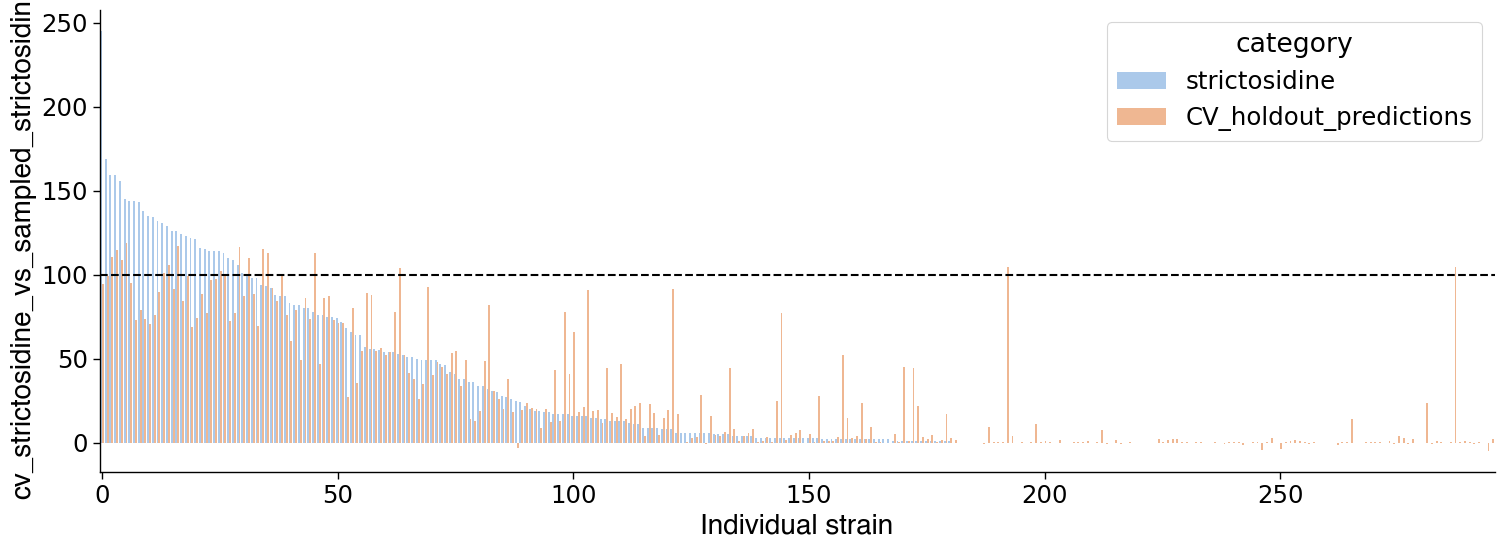

In [101]:
bar_plot_w_hue(dss, 'Line_name', 'strict', path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Bar_plot_prediction_vs_the_sampled_library',
              x_label = 'Individual strain',
               hue = 'category',
               palette = 'pastel',
               y_label= 'cv_strictosidine_vs_sampled_strictosidine', 
                size_height = 6,
                size_length = 18
              )

#### CV-Holdout predictions vs measured correlation plot

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


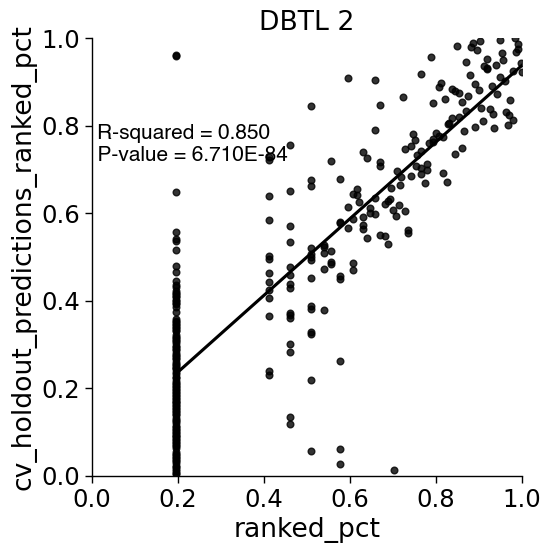

In [102]:
correlation_plot(df3,"ranked_pct","cv_holdout_predictions_ranked_pct",
                path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/corr_plot_ranked',
                title= 'DBTL 2',

                size_height = 5, 
                size_length= 5)

### 4.3 Find predicted genotypes

In [103]:
import numpy as np

In [104]:
all_genotypes = pd.read_csv('G8H_CPR_library/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [105]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [106]:
input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,1,2,5,1
1,1,2,5,9
2,2,4,7,3
3,2,1,5,7
4,3,3,6,1
...,...,...,...,...
124,4,1,6,1
125,5,2,6,3
126,3,1,6,3
127,5,1,6,6


### 4.4 Getting rid of the genotypes we have already tested:

In [107]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff.to_csv('G8H_CPR_library/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_second_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [108]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### 4.5 Predict the phenotype from the genotype of the unseen library

In [109]:
predicted = best_model.predict(all_genotypes_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [110]:
len(predicted)

1046

In [111]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,0.208979
1,0.282979
2,0.895885
3,0.767943
4,0.149506


In [112]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
614,5,2,6,8,121.887856
610,5,2,6,4,120.655922
748,6,2,6,2,118.661545
752,6,2,6,8,116.150963
605,5,2,5,8,115.912682
...,...,...,...,...,...
862,7,1,7,1,-6.313099
864,7,1,7,3,-6.768794
865,7,1,7,4,-7.006977
866,7,1,7,5,-7.386846


If we want the names on the genotypes we can do the following: 

In [113]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

### 4.6 Find best genotypes through both runs 


In [114]:
# import the cross validated dataframe 
df4 = pd.read_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')

g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

dbtl_cycle = []
# adding index of genotypes to individual rows 
for index, row in df4.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    #predicted_list.append(row['predicted_norm_strict'])
    if int(row['index']) < 167:
        dbtl_cycle.append(1)
    else: 
        dbtl_cycle.append(2)


    
df4['G8H'] = g8h_genotype
df4['pG8H'] = pg8h_genotype
df4['pCPR'] = pcpr_genotype
df4['CPR'] = cpr_genotype
df4['names'] = df4['G8H']+'-' +df4['pG8H']+ '_'+ df4['pCPR']+'_'+df4['CPR']
df4['dbtl_cycle'] = dbtl_cycle

df4

,Unnamed: 0,index,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct,G8H,pG8H,pCPR,CPR,names,dbtl_cycle
0,0,73,yp50_D03,5,2,6,3,85.210149,245,94.520157,1.000000,0.922297,Smus,ENO2,TPI1,Ara,Smus-ENO2_TPI1_Ara,1
1,1,205,yp53_D09,5,2,6,5,47.692027,169,99.468376,0.996622,0.942568,Smus,ENO2,TPI1,Rse,Smus-ENO2_TPI1_Rse,2
2,2,193,yp53_C06,6,2,6,4,44.848557,159,110.375237,0.991554,0.976351,Rsep,ENO2,TPI1,Clo,Rsep-ENO2_TPI1_Clo,2
3,3,171,yp53_A07,5,2,6,2,44.719792,159,114.916611,0.991554,0.986486,Smus,ENO2,TPI1,Aan,Smus-ENO2_TPI1_Aan,2
4,4,75,yp50_G03,6,2,6,5,54.362482,156,108.625351,0.986486,0.969595,Rsep,ENO2,TPI1,Rse,Rsep-ENO2_TPI1_Rse,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,291,105,yp50_F08,6,4,7,3,0.000000,0,-0.719766,0.195946,0.030405,Rsep,RPL15B,MLS1,Ara,Rsep-RPL15B_MLS1_Ara,1
292,292,108,yp50_A10,4,4,8,4,0.101052,0,0.582005,0.195946,0.317568,Vmin,RPL15B,URE2,Clo,Vmin-RPL15B_URE2_Clo,1
293,293,114,yp50_D11,5,4,8,6,0.000000,0,0.015273,0.195946,0.152027,Smus,RPL15B,URE2,Ahu,Smus-RPL15B_URE2_Ahu,1
294,294,117,yp50_B12,4,1,7,8,0.000000,0,-4.872061,0.195946,0.003378,Vmin,CYC1,MLS1,Cac,Vmin-CYC1_MLS1_Cac,1


lets take the average of the best genotypes

In [115]:
df_mean_normalized_val = df4.groupby('names', as_index=False)['Amt_norm'].mean().sort_values(by='Amt_norm')
df_mean_normalized_val.columns =['names','Average_Amt_norm' ] 


df_mean_normalized_with_all_other_values = df4.merge(df_mean_normalized_val, how='outer', on='names')
df_mean_normalized_with_all_other_values.sort_values(by='Average_Amt_norm', ascending=False)


,Unnamed: 0,index,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct,G8H,pG8H,pCPR,CPR,names,dbtl_cycle,Average_Amt_norm
7,3,171,yp53_A07,5,2,6,2,44.719792,159,114.916611,0.991554,0.986486,Smus,ENO2,TPI1,Aan,Smus-ENO2_TPI1_Aan,2,159.0
14,7,86,yp50_E05,5,1,6,8,50.194227,144,72.949486,0.978041,0.814189,Smus,CYC1,TPI1,Cac,Smus-CYC1_TPI1_Cac,1,144.0
15,8,189,yp53_C01,5,1,5,4,40.340558,143,78.878197,0.972973,0.858108,Smus,CYC1,CCW12,Clo,Smus-CYC1_CCW12_Clo,2,143.0
5,2,193,yp53_C06,6,2,6,4,44.848557,159,110.375237,0.991554,0.976351,Rsep,ENO2,TPI1,Clo,Rsep-ENO2_TPI1_Clo,2,142.5
6,16,194,yp53_C07,6,2,6,4,35.604401,126,117.319481,0.947635,0.996622,Rsep,ENO2,TPI1,Clo,Rsep-ENO2_TPI1_Clo,2,142.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,212,11,yp49_F02,3,4,5,1,0.152172,0,7.491556,0.195946,0.516892,Cro,RPL15B,CCW12,Cro,Cro-RPL15B_CCW12_Cro,1,0.0
218,211,10,yp49_D02,2,4,5,3,0.291422,0,0.174243,0.195946,0.202703,Opum,RPL15B,CCW12,Ara,Opum-RPL15B_CCW12_Ara,1,0.0
217,210,9,yp49_C02,1,3,8,9,0.047391,0,-0.014198,0.195946,0.138514,Cacu,PCK1,URE2,Oeu,Cacu-PCK1_URE2_Oeu,1,0.0
216,209,8,yp49_B02,1,2,8,5,0.071350,0,0.779940,0.195946,0.344595,Cacu,ENO2,URE2,Rse,Cacu-ENO2_URE2_Rse,1,0.0


In [116]:
# getting the avarage
average_df = df4[['names', 'Amt_norm','Amt_uM_Strictosidine' ]]
average_df = average_df.groupby(by= 'names').mean(numeric_only=False)
average_df = average_df.sort_values(by='Amt_norm', ascending=False)

# finding out in which round we saw the genotype first
df5 = df4.merge(average_df, how='inner', on='names')
df5 = df5[['names','Amt_uM_Strictosidine_x','Amt_uM_Strictosidine_y','Amt_norm_x',  'Amt_norm_y','dbtl_cycle']]
#df5.columns = ['names', 'Average_Amt_norm','dbtl_cycle']

#df5
# # Drop duplicates 
df5 = df5.drop_duplicates(subset=['names'], keep='first')
df5 = df5.sort_values(by='Amt_norm_y', ascending=False).reset_index()

# adding colors 
colors = []
for index, row in df5.iterrows():
    if int(row['dbtl_cycle']) == 1:
        colors.append('#86cdeb4c')
    if int(row['dbtl_cycle']) == 2:
        colors.append('#87ceebff')

df5

,index,names,Amt_uM_Strictosidine_x,Amt_uM_Strictosidine_y,Amt_norm_x,Amt_norm_y,dbtl_cycle
0,7,Smus-ENO2_TPI1_Aan,44.719792,44.719792,159,159.000000,2
1,14,Smus-CYC1_TPI1_Cac,50.194227,50.194227,144,144.000000,1
2,15,Smus-CYC1_CCW12_Clo,40.340558,40.340558,143,143.000000,2
3,5,Rsep-ENO2_TPI1_Clo,44.848557,40.226479,159,142.500000,2
4,8,Rsep-ENO2_TPI1_Rse,54.362482,41.662051,156,135.666667,1
...,...,...,...,...,...,...,...
229,219,Cro-RPL15B_CCW12_Cro,0.152172,0.152172,0,0.000000,1
230,218,Opum-RPL15B_CCW12_Ara,0.291422,0.291422,0,0.000000,1
231,217,Cacu-PCK1_URE2_Oeu,0.047391,0.047391,0,0.000000,1
232,216,Cacu-ENO2_URE2_Rse,0.071350,0.071350,0,0.000000,1


In [117]:
from teemi.learn.plotting import horisontal_bar_plot

In [118]:
x_axis = list(df5['names'])[:20][::-1]
y_axis = list(df5['Amt_norm_y'])[:20][::-1]
colors = colors[:20][::-1]
horisontal_bar_plot

<function teemi.learn.plotting.horisontal_bar_plot(x: list, y: list, vertical_line: bool = True, save_pdf: bool = True, path: str = '', color='white', title=None, x_label=None, y_label=None, size_height: int = 10, size_length: int = 8, legend=False) -> None>

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


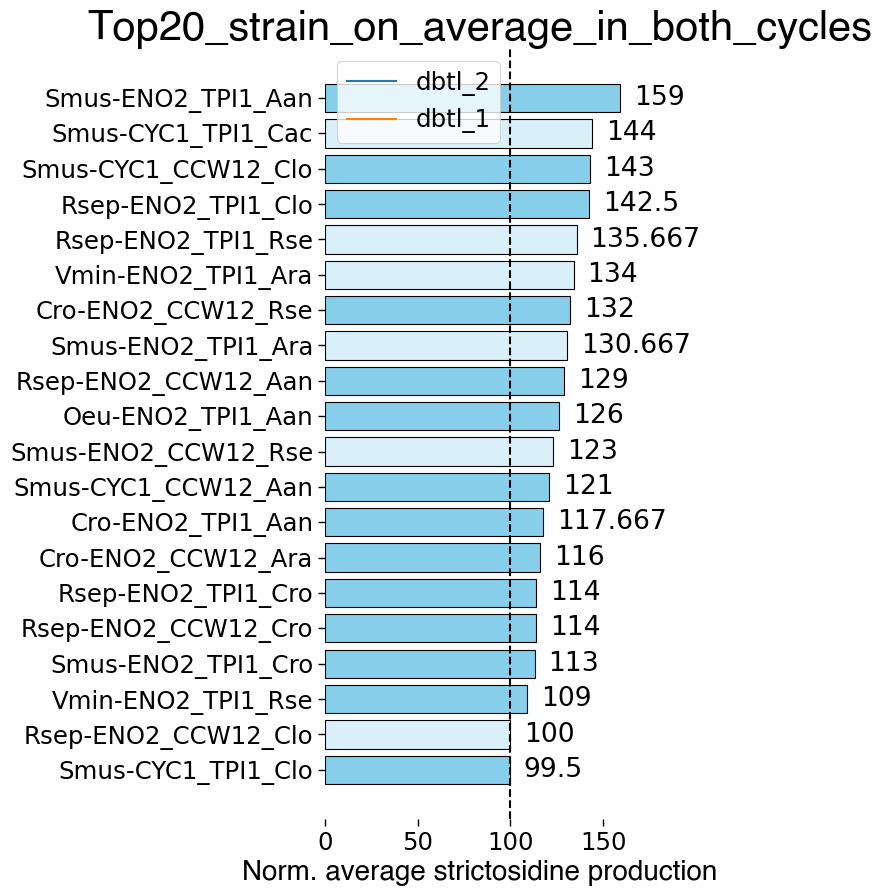

In [119]:
horisontal_bar_plot(x_axis,y_axis,  path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Top20_strain_on_average_in_both_cycles', 
                    title = 'Top20_strain_on_average_in_both_cycles', 
                   size_height=4, 
                   color = colors,
                   size_length=10, 
                   x_label='Norm. average strictosidine production', 
                   legend = True)

## 5. Top 20 predicted producers

In [120]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cac,121.887856
1,Smus,ENO2,TPI1,Clo,120.655922
2,Rsep,ENO2,TPI1,Aan,118.661545
3,Rsep,ENO2,TPI1,Cac,116.150963
4,Smus,ENO2,CCW12,Cac,115.912682
5,Smus,ENO2,CCW12,Aan,115.522354
6,Smus,ENO2,CCW12,Clo,114.77845
7,Smus,ENO2,CCW12,Ara,110.120384
8,Rsep,ENO2,CCW12,Rse,109.848526
9,Rsep,ENO2,CCW12,Cac,108.326645


Saving the predictions

In [121]:
#Top20
df_with_genotypes_top20 = df_with_genotypes[:20]
df_with_genotypes_top20.to_csv('G8H_CPR_library/data/09-AutoML/Top20_predictions/second_round/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv')

# All predictions
df_with_genotypes.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv', index=False)

In [122]:
from teemi.learn.plotting import bar_plot
bar_plot

<function teemi.learn.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

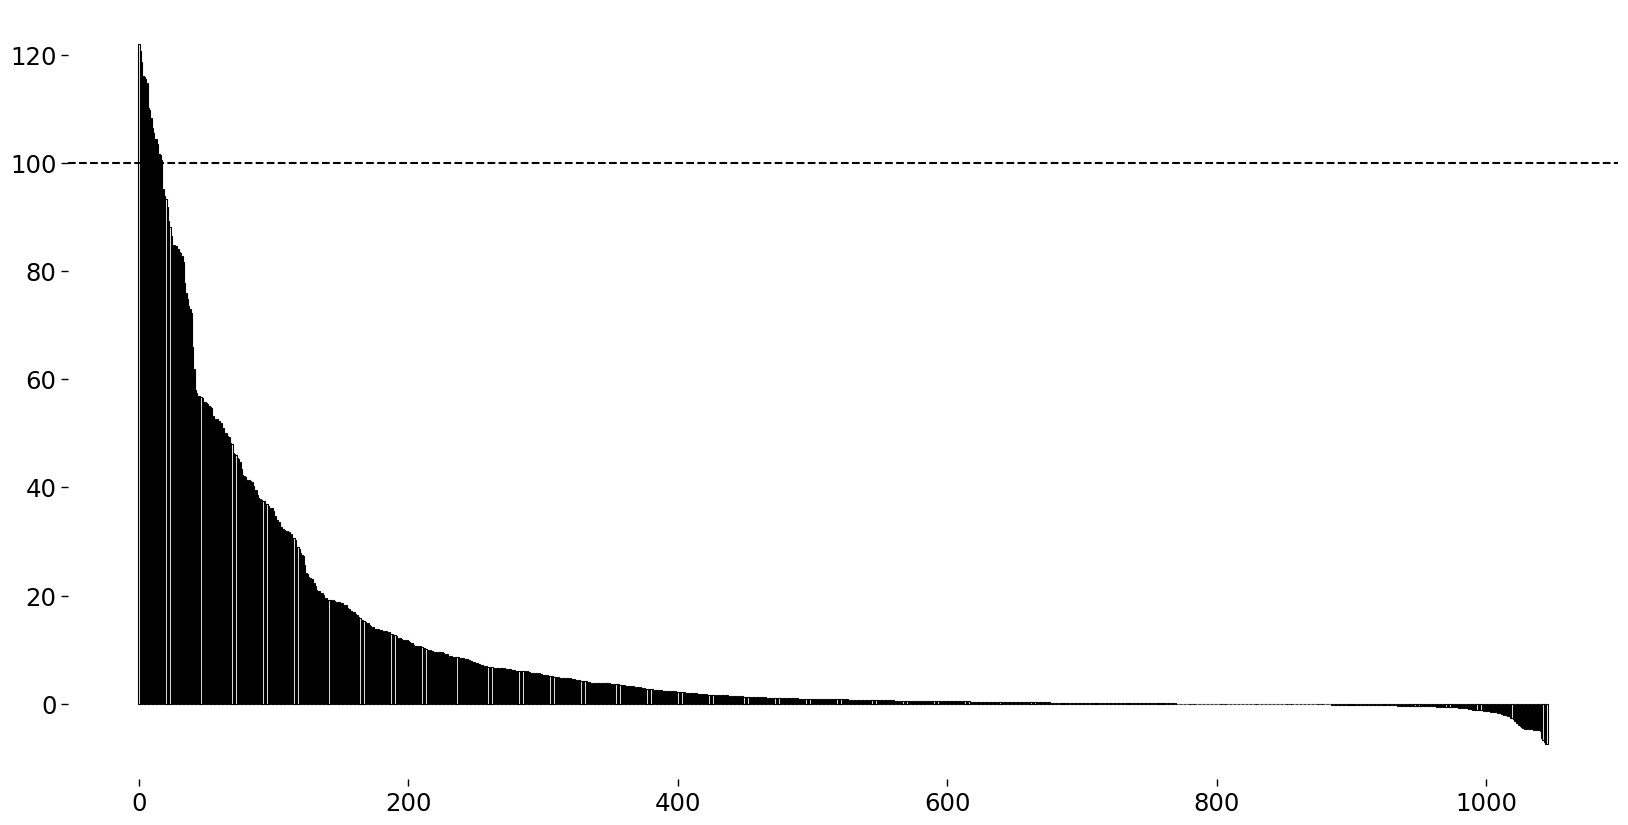

In [123]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y,
         path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/barplot_predicting_remaining_best_combinations',
         size_height =  10, 
         size_length = 20)

In [124]:
df_with_genotypes = pd.read_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv')

In [125]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [126]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production,names
0,Smus,ENO2,TPI1,Cac,121.887856,Smus-ENO2_TPI1_Cac
1,Smus,ENO2,TPI1,Clo,120.655922,Smus-ENO2_TPI1_Clo
2,Rsep,ENO2,TPI1,Aan,118.661545,Rsep-ENO2_TPI1_Aan
3,Rsep,ENO2,TPI1,Cac,116.150963,Rsep-ENO2_TPI1_Cac
4,Smus,ENO2,CCW12,Cac,115.912682,Smus-ENO2_CCW12_Cac
...,...,...,...,...,...,...
1041,Oeu,CYC1,MLS1,Cro,-6.313099,Oeu-CYC1_MLS1_Cro
1042,Oeu,CYC1,MLS1,Ara,-6.768794,Oeu-CYC1_MLS1_Ara
1043,Oeu,CYC1,MLS1,Clo,-7.006977,Oeu-CYC1_MLS1_Clo
1044,Oeu,CYC1,MLS1,Rse,-7.386846,Oeu-CYC1_MLS1_Rse


In [127]:
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

In [128]:
from teemi.learn.plotting import horisontal_bar_plot

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


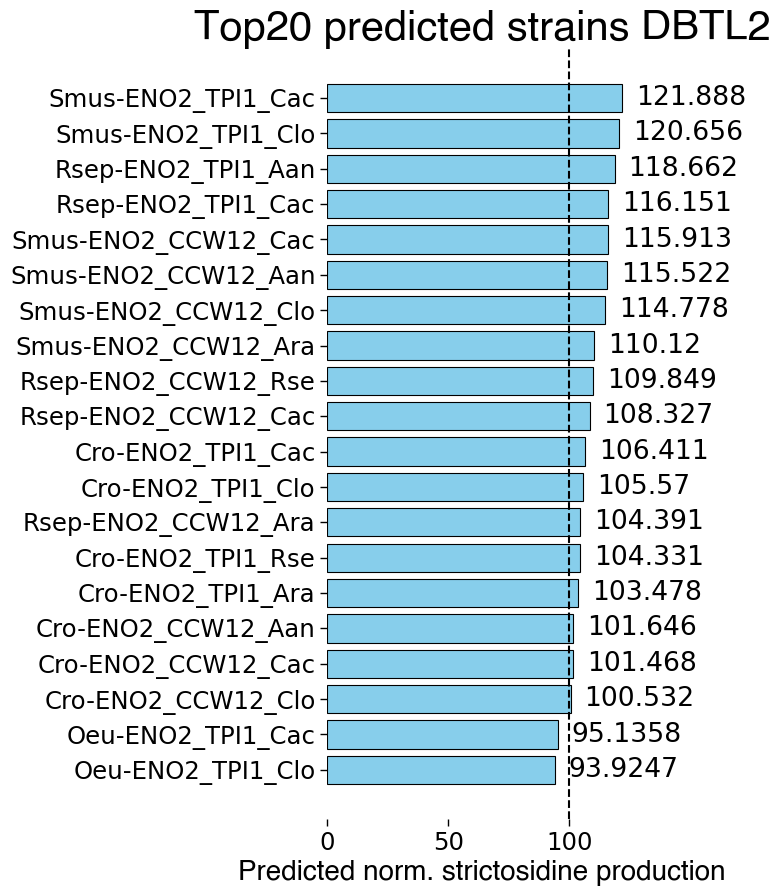

In [129]:
horisontal_bar_plot(x_axis,y_axis,  path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Top20_predicted_strains_ML2', 
                    title = 'Top20 predicted strains DBTL2', 
                    size_height=4, 
                   color = '#87CEEB',
                   size_length=10, 
                   x_label='Predicted norm. strictosidine production', 
                   legend = False)

### 5.1 How many genotypes are predicted to produce more than the control strain?

In [130]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} are PREDICTED to produce strictosidine over the normalized value")
print(f"Out of the remaining theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}%")

18 strains out of 1046 are PREDICTED to produce strictosidine over the normalized value
Out of the remaining theoretical space these constittue : 1.7208413001912046%


### 5.2 How well does the model predict on the old library i.e. 1121? Do we get the same genotypes when sorting for the best as the the first model? 

In [131]:
all_genotypes_1121 = pd.read_csv('G8H_CPR_library/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv', index_col= False)
all_genotypes =all_genotypes_1121[['0','1','2','3']]
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))

# Predict
predicted = best_model.predict(all_genotypes_df)

# make to dataframe
predicted_norm = predicted.as_data_frame()

# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
all_genotypes_1121['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = all_genotypes_1121.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round_model_on_old_library/top_predictions_by_second_round_model_on_data_from_the_first_round.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [132]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [133]:
ML2_recomendations = pd.DataFrame(list_of_lists )
ML2_recomendations = ML2_recomendations.T

ML2_recomendations.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
ML2_recomendations100 = ML2_recomendations[:100]

In [134]:
# what it recomended in first round 
ML1_recomendations = pd.read_csv('G8H_CPR_library/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')
ML1_recomendations100 = ML1_recomendations[0:100]
ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'

ML1_recomendations100

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/1923506259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/1923506259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'


,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,SmusG8H,ENO2,TPI1,CroCPR,189.410583
1,SmusG8H,ENO2,TPI1,CacCPR,184.930663
2,SmusG8H,ENO2,TPI1,AanCPR,183.786563
3,RsepG8H,ENO2,TPI1,AraCPR,179.451003
4,SmusG8H,ENO2,CCW12,AraCPR,177.130989
...,...,...,...,...,...
95,RsepG8H,ENO2,MLS1,AraCPR,52.550943
96,CroG8H,ENO2,CCW12,CloCPR,49.530658
97,SmusG8H,ENO2,MLS1,AanCPR,49.530375
98,OeuG8H,CYC1,TPI1,CacCPR,48.881757


In [135]:
ML1_recomendations100 = ML1_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100 = ML2_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100

,G8H,pG8H,pCPR,CPR
0,SmusG8H,ENO2,TPI1,AanCPR
1,SmusG8H,ENO2,TPI1,CacCPR
2,SmusG8H,ENO2,TPI1,CloCPR
3,RsepG8H,ENO2,TPI1,AanCPR
4,RsepG8H,ENO2,TPI1,CloCPR
...,...,...,...,...
95,OeuG8H,ENO2,URE2,CloCPR
96,RsepG8H,CYC1,CCW12,OeuCPR
97,RsepG8H,CYC1,TPI1,CroCPR
98,RsepG8H,CYC1,TPI1,OeuCPR


In [136]:
comparison = ML1_recomendations100.compare(ML2_recomendations100, keep_shape=True, keep_equal=True)
comparison

G8H           pG8H         pCPR            CPR        
       self    other  self other   self  other    self   other
0   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  CroCPR  AanCPR
1   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  CacCPR  CacCPR
2   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  AanCPR  CloCPR
3   RsepG8H  RsepG8H  ENO2  ENO2   TPI1   TPI1  AraCPR  AanCPR
4   SmusG8H  RsepG8H  ENO2  ENO2  CCW12   TPI1  AraCPR  CloCPR
..      ...      ...   ...   ...    ...    ...     ...     ...
95  RsepG8H   OeuG8H  ENO2  ENO2   MLS1   URE2  AraCPR  CloCPR
96   CroG8H  RsepG8H  ENO2  CYC1  CCW12  CCW12  CloCPR  OeuCPR
97  SmusG8H  RsepG8H  ENO2  CYC1   MLS1   TPI1  AanCPR  CroCPR
98   OeuG8H  RsepG8H  CYC1  CYC1   TPI1   TPI1  CacCPR  OeuCPR
99  SmusG8H   OeuG8H  ENO2  ENO2   TPI1   URE2  AhuCPR  RseCPR

[100 rows x 8 columns]

In [137]:
comparison.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round_model_on_old_library/ML1_top_predicted_vs_ML2_top100_predicted.csv')

In [138]:
top_x = 25

difference = pd.concat([ML1_recomendations100[:top_x],ML2_recomendations100[:top_x]]).drop_duplicates(keep=False)
the_same_rows = len(ML1_recomendations100) -len(difference)
print(f'The top{top_x} predictions from the ML model in the second dbtl are shared by the first round by {the_same_rows/len(ML1_recomendations100)*100}%')

The top25 predictions from the ML model in the second dbtl are shared by the first round by 86.0%


### 5.3 Plotting the top predictions 

In [139]:
from teemi.learn.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8H_color= color_range_dict()['blue'][::3][::-1]
print(len(g8H_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [140]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]
all_parts = g8h_list_of_index + pg8h_list_of_index+pcpr_list_of_index+cpr_list_of_index

G8H_color_codes = dict(zip(g8h_list_of_index, g8H_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)

In [141]:
from teemi.learn.plotting import carpet_barplot

25


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


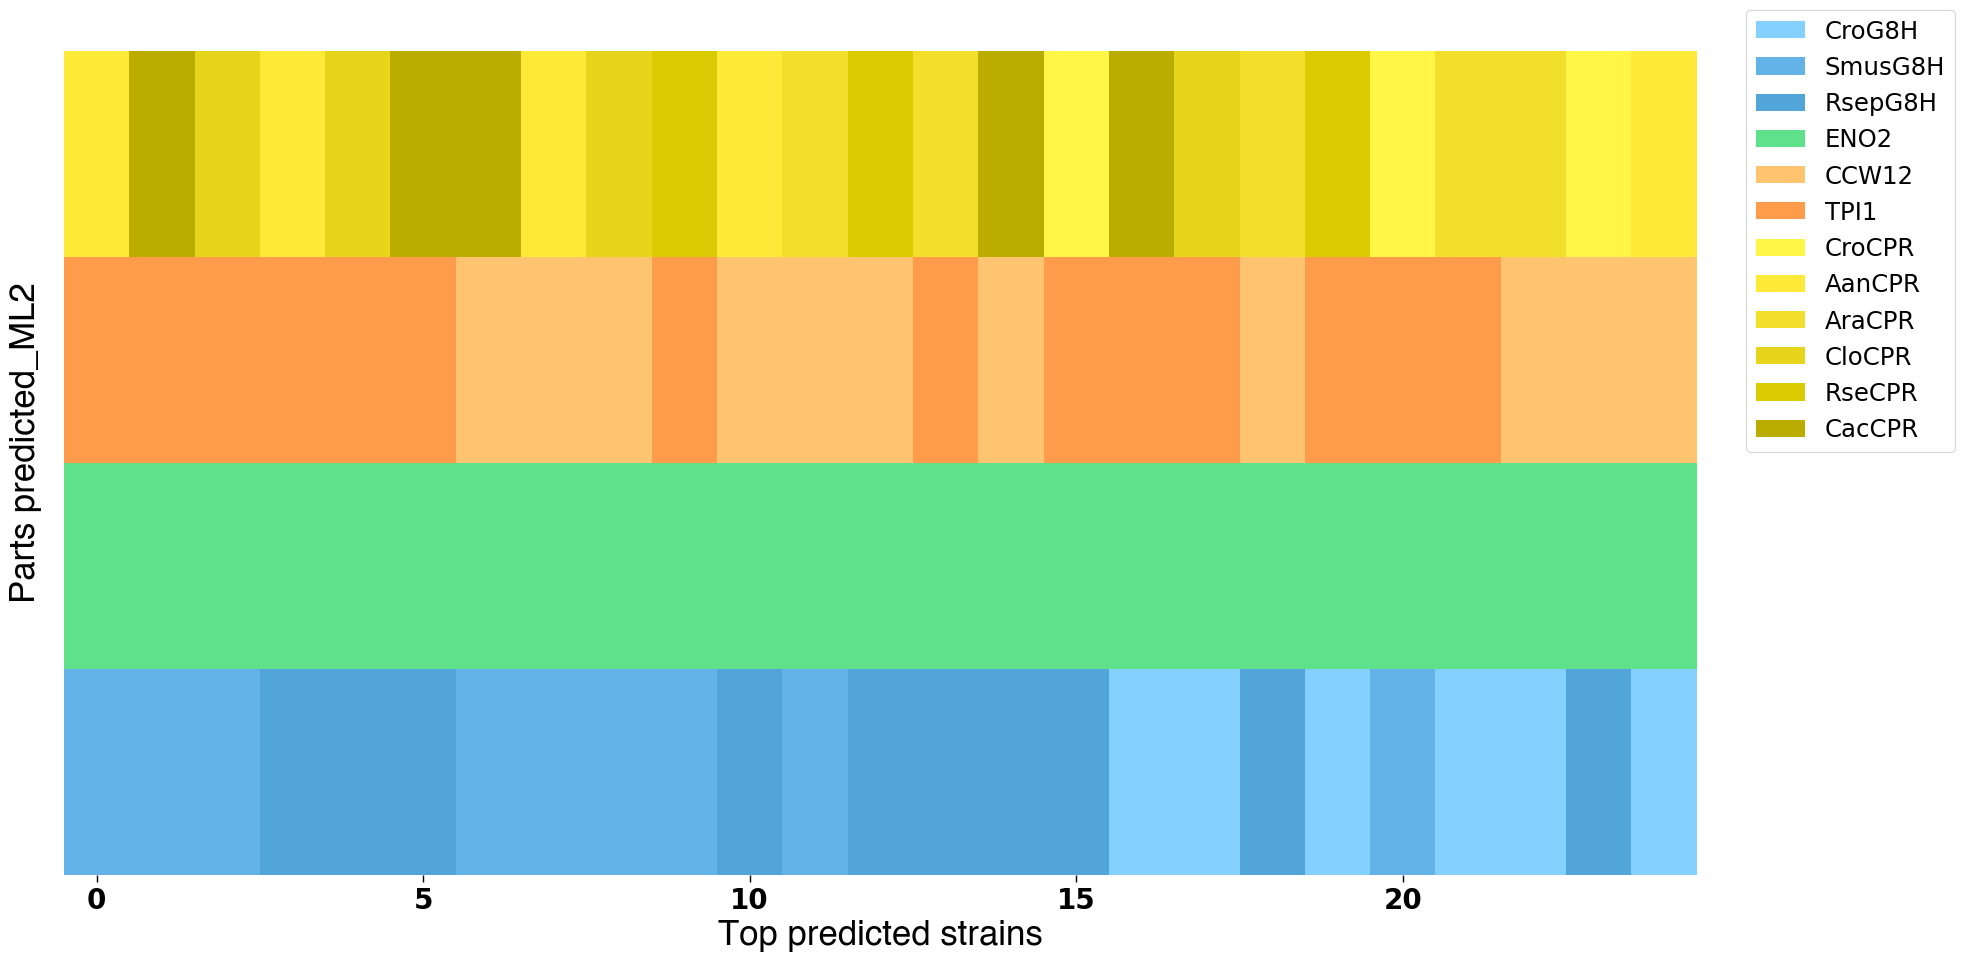

In [142]:
ML2_recomendations100['Index'] = ML2_recomendations100.index
list_of_parts = []
parst_index = []

for index, row in ML2_recomendations100.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)

d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

# slice df
df200 = df2[:100]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

coloumns = list(cross_tab_prop.columns)


print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

name = 'Best_combinations_predicted_by_the_ML2_25'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/'+name, xlabel ='Top predicted strains' ,
               ylabel = 'Parts predicted_ML2', 
              size_height= 10, 
              size_length=20) 



25


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


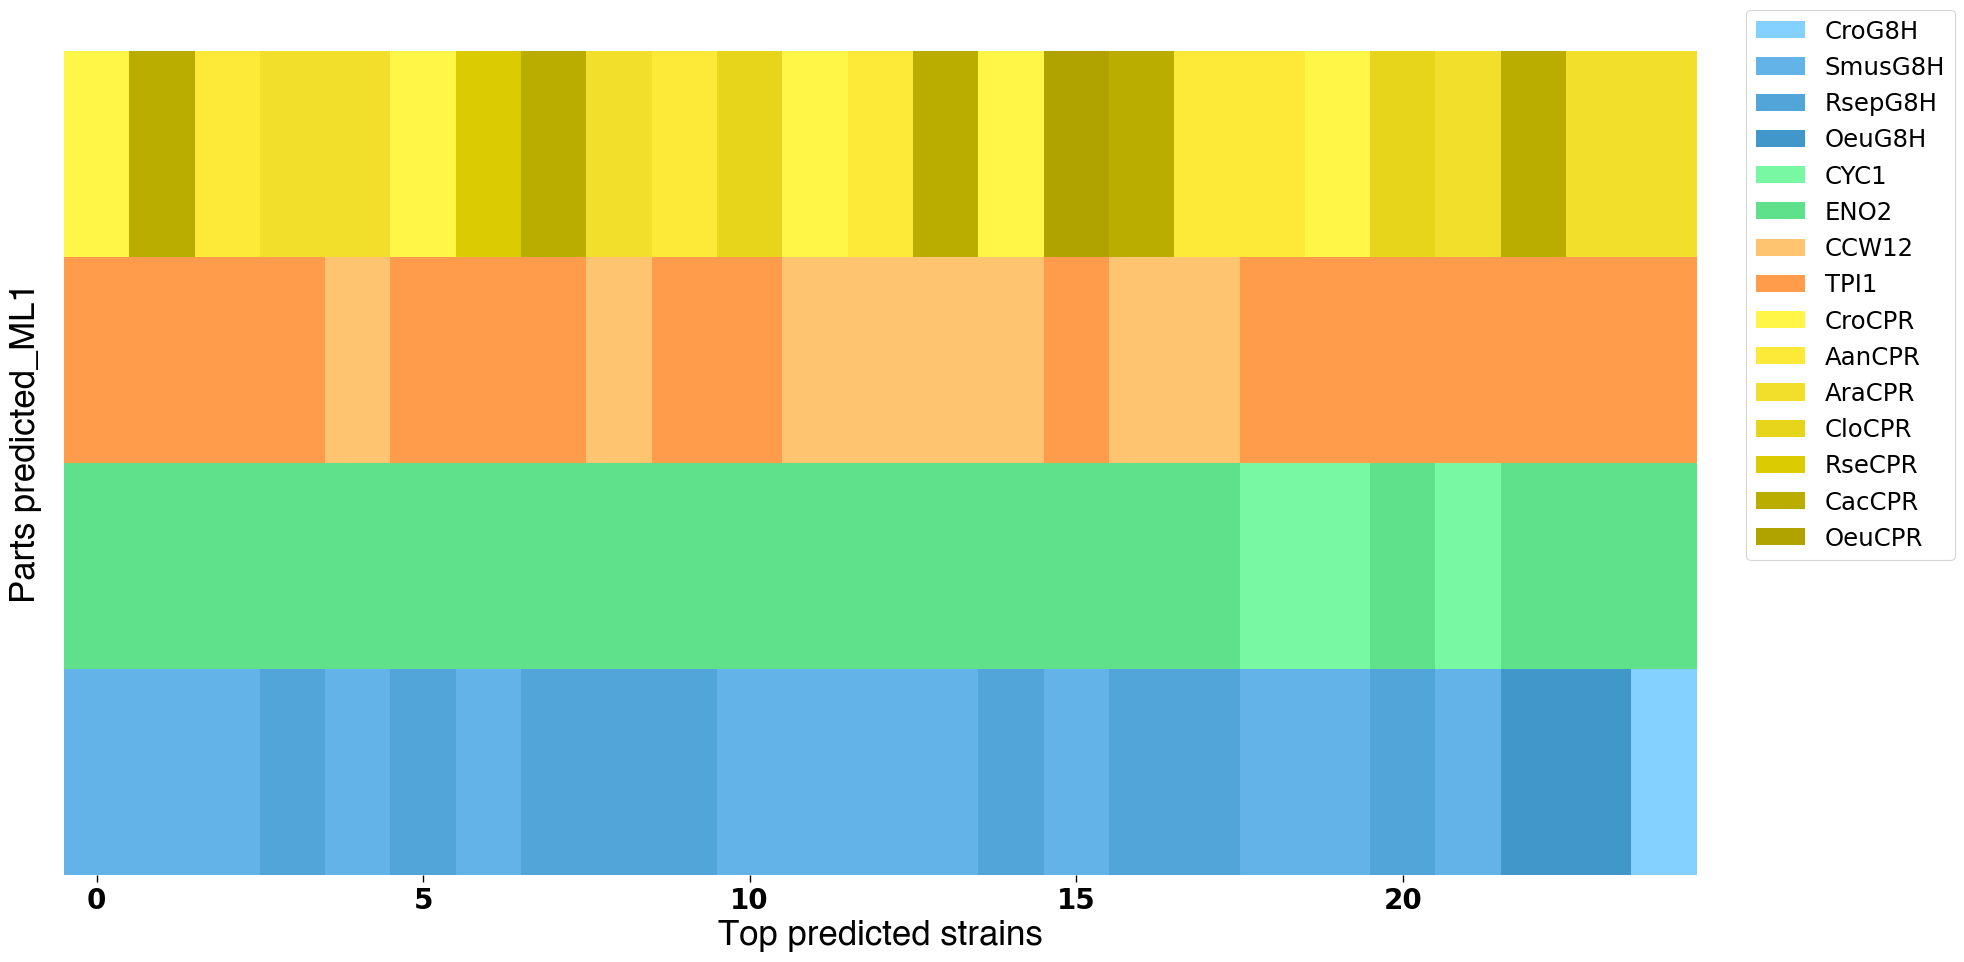

In [143]:
ML1_recomendations100['Index'] = ML1_recomendations100.index
list_of_parts = []
parst_index = []

for index, row in ML1_recomendations100.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)

d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

# slice df
df100 = df2[:100]
cross_tab_prop = pd.crosstab(index=df100['Index'],
                             columns=df100['Part'])

coloumns = list(cross_tab_prop.columns)


print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

name = 'Best_combinations_predicted_by_the_ML_25'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/'+name, xlabel ='Top predicted strains' ,
               ylabel = 'Parts predicted_ML1', 
              size_height= 10, 
              size_length=20) 


#### 5.3.1 How  many recomendations overlap with the top strains already built in the second cycle? 



In [144]:
second_input_for_ml = second_input_for_ml.sort_values(by=['Amt_norm'], ascending=False)

In [145]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['Amt_norm'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [146]:
DBTL2_top_strains = pd.DataFrame(list_of_lists )
DBTL2_top_strains = DBTL2_top_strains.T

# name the columns
DBTL2_top_strains.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Amt_norm']
DBTL2_top_strains_top100 = DBTL2_top_strains[:100]
DBTL2_top_strains_top100.head(30)

,G8H,pG8H,pCPR,CPR,Amt_norm
0,SmusG8H,ENO2,TPI1,RseCPR,169.631396
1,RsepG8H,ENO2,TPI1,CloCPR,159.517718
2,SmusG8H,ENO2,TPI1,AanCPR,159.059724
3,RsepG8H,ENO2,TPI1,RseCPR,145.152656
4,CroG8H,ENO2,TPI1,AanCPR,144.982414
5,SmusG8H,CYC1,CCW12,CloCPR,143.48363
6,CroG8H,ENO2,TPI1,CroCPR,138.267757
7,CroG8H,ENO2,CCW12,RseCPR,132.656867
8,RsepG8H,ENO2,CCW12,AanCPR,129.715993
9,OeuG8H,ENO2,TPI1,AanCPR,126.954886


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/1321850698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL2_top_strains_top100['Index'] = DBTL2_top_strains_top100.index


25


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


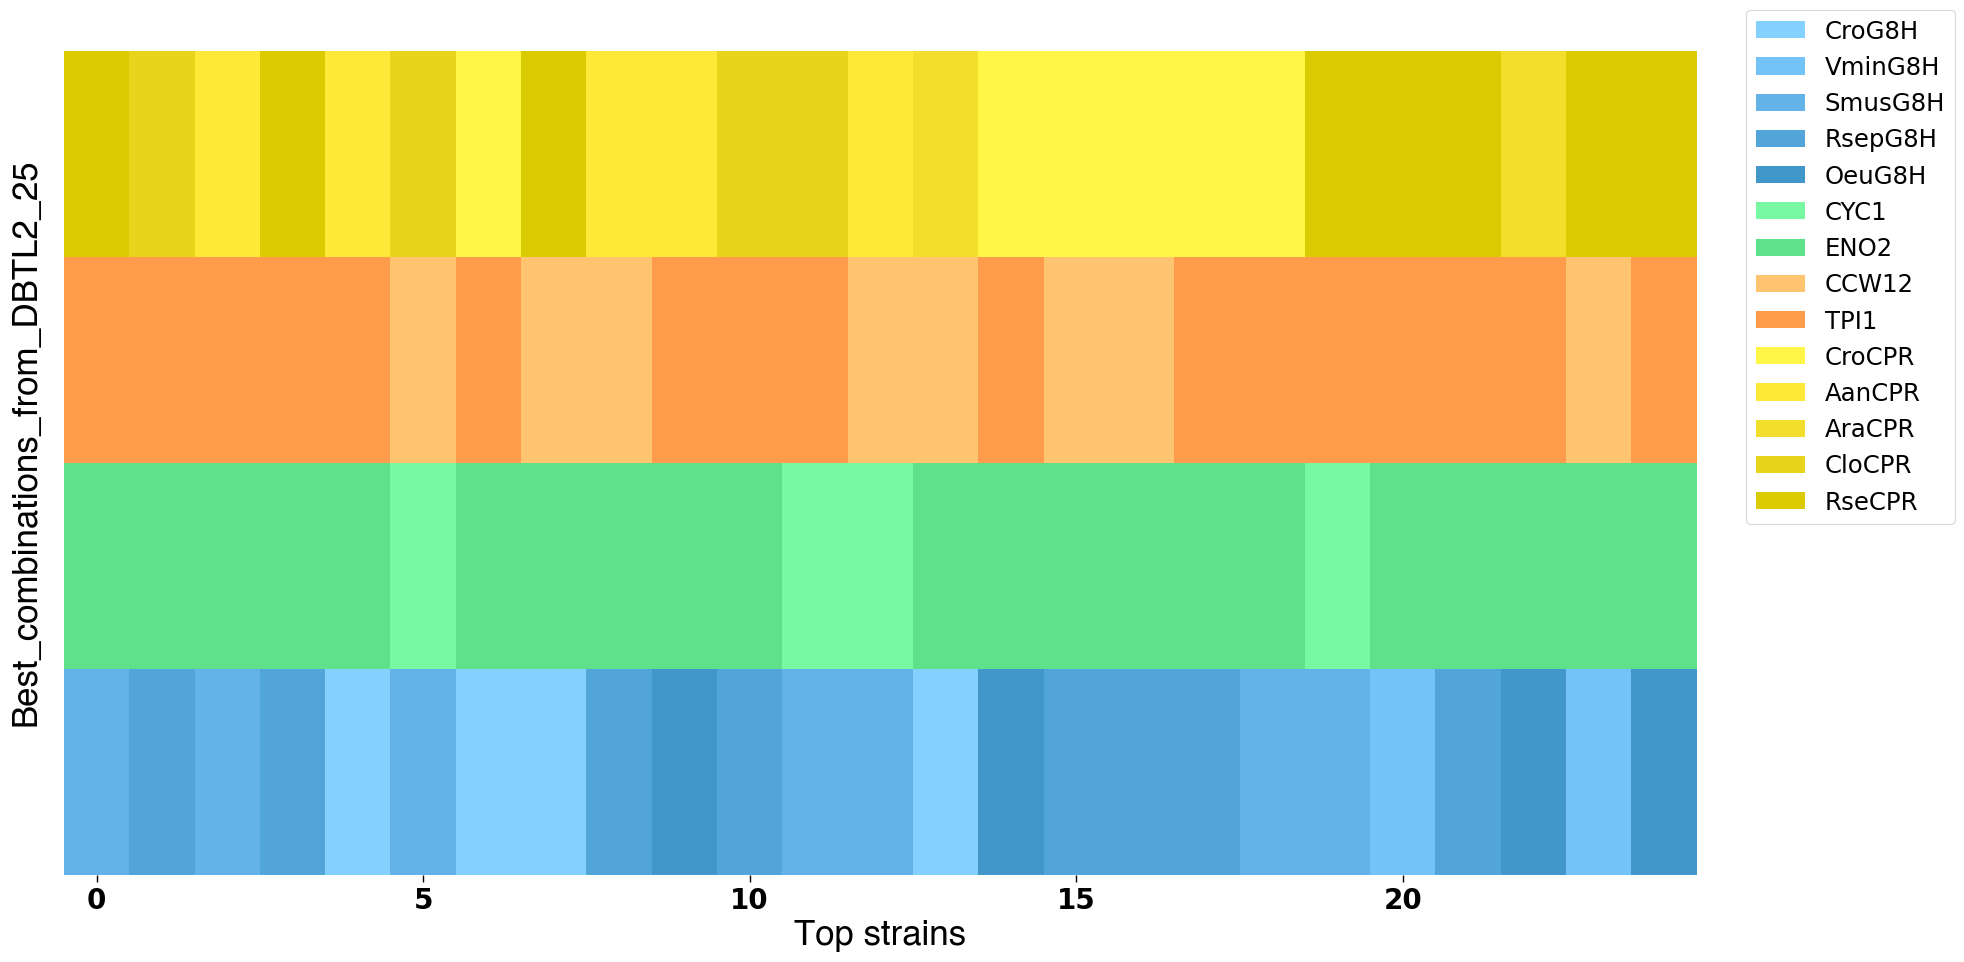

In [147]:
DBTL2_top_strains_top100['Index'] = DBTL2_top_strains_top100.index
list_of_parts = []
parst_index = []

for index, row in DBTL2_top_strains_top100.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)

d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

# slice df
df200 = df2[:100]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

coloumns = list(cross_tab_prop.columns)


print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

name = 'Best_combinations_from_DBTL2_25'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/'+name, 
               xlabel ='Top strains' ,
               ylabel = 'Best_combinations_from_DBTL2_25', 
              size_height= 10, 
              size_length=20) 



In [148]:
DBTL2_top_strains_top100 = DBTL2_top_strains_top100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100 = ML2_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100

,G8H,pG8H,pCPR,CPR
0,SmusG8H,ENO2,TPI1,AanCPR
1,SmusG8H,ENO2,TPI1,CacCPR
2,SmusG8H,ENO2,TPI1,CloCPR
3,RsepG8H,ENO2,TPI1,AanCPR
4,RsepG8H,ENO2,TPI1,CloCPR
...,...,...,...,...
95,OeuG8H,ENO2,URE2,CloCPR
96,RsepG8H,CYC1,CCW12,OeuCPR
97,RsepG8H,CYC1,TPI1,CroCPR
98,RsepG8H,CYC1,TPI1,OeuCPR


In [149]:
comparison = DBTL2_top_strains_top100.compare(ML2_recomendations100, keep_shape=True, keep_equal=True)
comparison

G8H           pG8H         pCPR            CPR        
       self    other  self other   self  other    self   other
0   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  RseCPR  AanCPR
1   RsepG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  CloCPR  CacCPR
2   SmusG8H  SmusG8H  ENO2  ENO2   TPI1   TPI1  AanCPR  CloCPR
3   RsepG8H  RsepG8H  ENO2  ENO2   TPI1   TPI1  RseCPR  AanCPR
4    CroG8H  RsepG8H  ENO2  ENO2   TPI1   TPI1  AanCPR  CloCPR
..      ...      ...   ...   ...    ...    ...     ...     ...
95  RsepG8H   OeuG8H  CYC1  ENO2  CCW12   URE2  AhuCPR  CloCPR
96  RsepG8H  RsepG8H  CYC1  CYC1   TPI1  CCW12  AraCPR  OeuCPR
97  VminG8H  RsepG8H  ENO2  CYC1  CCW12   TPI1  AhuCPR  CroCPR
98   OeuG8H  RsepG8H  ENO2  CYC1  CCW12   TPI1  AniCPR  OeuCPR
99  VminG8H   OeuG8H  CYC1  ENO2   TPI1   URE2  AraCPR  RseCPR

[100 rows x 8 columns]

In [150]:
comparison.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round_model_on_old_library/DBTL2_top_strains_vs_ML2_top100_predicted.csv')

In [151]:
top_x = 25

difference = pd.concat([DBTL2_top_strains_top100[:top_x],ML2_recomendations100[:top_x]]).drop_duplicates(keep=False)
the_same_rows = len(DBTL2_top_strains_top100) -len(difference)
print(f'The top{top_x} predictions from the ML model in the second dbtl are shared by the first round by {the_same_rows/len(DBTL2_top_strains_top100)*100}%')

The top25 predictions from the ML model in the second dbtl are shared by the first round by 70.0%


## 6. Learning curve on data

In [152]:
from teemi.learn.auto_ml import autoML_on_partitioned_data

In [153]:
ml_input_w_duplicates = new_input_for_ml[['Line_name',	'0'	,'1','2','3','Amt_norm']]
ml_input_w_duplicates

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.922793
1,yp49_C01,1,2,5,9,0.509123
2,yp49_D01,2,4,7,3,0.166871
3,yp49_E01,2,1,5,7,0.327489
4,yp49_F01,3,3,6,1,25.060934
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


The following function takes ~50 hours to run on my macbook pro M1. ¨


1. It trains models on partitions of the data meaning that it splits the data into equally sized partitions. 
2. Then it shuffles the data and trains models on these partitions. 
3. Finally it creates a csv file with the MAE for the best model, CV MAE and CV Standard deviation and model name. 

Cross-validation metric nfold = 5 was chosen to not get better predictions on the smallest partion ~60 datapoints. 

In [154]:
run_ML = False
if run_ML:
    feature_cols = ['0', '1', '2', '3']
    training_column = 'Amt_norm'

   # Training 5 partitions 10 times - the function is set to nfold = 5  by default.  for i in range(0,10)
    for i in range(0,10): 
        # shuffle dataset each time we make a dataframe
        ml_input_w_duplicates = ml_input_w_duplicates.sample(frac=1, random_state= i).reset_index(drop=True) # Random state sets a seed on the shuffeling

        autoML_on_partitioned_data(feature_cols,                # Which features to use for training
                                 training_column,               # Which colum to use for training
                                 ml_input_w_duplicates,         # Input data to train on
                                 training_time=0, 
                                 partitions = 5,                # we get partitions that are around 60
                                 nfold= 5,
                                 path = 'G8H_CPR_library/data/09-AutoML/data_from_learning_curve/second_round/nfold_5/')

### 6.1 - Visiualizing the learning curve

In [155]:
import os
dir_path = 'G8H_CPR_library/data/09-AutoML/data_from_learning_curve/second_round/nfold_5/'

# list file and directories
res = os.listdir(dir_path)
res

['2023_04_04_10:27_ml_models_running_over_partioned_data.csv',
 '2023_04_03_19:22_ml_models_running_over_partioned_data.csv',
 '2023_04_04_05:26_ml_models_running_over_partioned_data.csv',
 '2023_04_05_02:17_ml_models_running_over_partioned_data.csv',
 '2023_04_05_07:06_ml_models_running_over_partioned_data.csv',
 '2023_04_05_11:49_ml_models_running_over_partioned_data.csv',
 '2023_04_04_00:24_ml_models_running_over_partioned_data.csv',
 '2023_04_03_14:21_ml_models_running_over_partioned_data.csv',
 '2023_03_31_22:37_ml_models_running_over_partioned_data.csv',
 '2023_03_31_17:37_ml_models_running_over_partioned_data.csv']

In [156]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [157]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,...,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
60,15.332924,22.646505,7.716324,GBM_grid_1_AutoML_80_20230404_52605_model_2,3.130672,18.948034,4.664009,XGBoost_grid_1_AutoML_65_20230403_142111_model_40,10.362573,13.219104,...,8.763880,StackedEnsemble_BestOfFamily_6_AutoML_60_20230...,2.565552,18.489079,3.598322,XGBoost_grid_1_AutoML_55_20230331_173702_model_70,10.119588,14.642888,3.664095,XGBoost_grid_1_AutoML_50_20230331_123802_model...
120,13.332550,18.863600,6.124240,GBM_grid_1_AutoML_81_20230404_62619_model_2,4.773067,16.052559,4.157420,XGBoost_grid_1_AutoML_66_20230403_152116_model_70,10.755439,16.496872,...,4.361866,StackedEnsemble_BestOfFamily_5_AutoML_61_20230...,5.361176,14.898401,4.134821,XGBoost_grid_1_AutoML_56_20230331_183718_model_91,4.834075,12.610052,1.520582,XGBoost_grid_1_AutoML_51_20230331_133813_model_91
180,3.944617,15.445626,3.756048,XGBoost_grid_1_AutoML_82_20230404_72650_model_8,9.703769,15.619384,1.370589,GBM_lr_annealing_selection_AutoML_67_20230403_...,12.120033,13.126437,...,1.871600,GBM_grid_1_AutoML_62_20230403_112019_model_44,13.853268,14.445418,4.550968,StackedEnsemble_BestOfFamily_6_AutoML_57_20230...,9.856842,13.797586,2.910647,GBM_grid_1_AutoML_52_20230331_143819_model_2
240,4.597889,14.263115,5.015804,XGBoost_grid_1_AutoML_83_20230404_82710_model_8,9.655581,14.775455,2.687903,GBM_lr_annealing_selection_AutoML_68_20230403_...,12.995119,13.997235,...,1.690692,GBM_grid_1_AutoML_63_20230403_122005_model_12,12.213021,14.328815,4.243171,StackedEnsemble_AllModels_5_AutoML_58_20230331...,8.625770,14.523786,3.514635,GBM_grid_1_AutoML_53_20230331_153812_model_12
296,10.048070,14.975159,4.542488,GBM_grid_1_AutoML_84_20230404_92713_model_12,9.828615,14.364637,2.237744,GBM_grid_1_AutoML_69_20230403_182229_model_12,10.173004,14.633537,...,1.038338,GBM_grid_1_AutoML_64_20230403_132041_model_12,11.373868,13.096806,1.382340,StackedEnsemble_BestOfFamily_6_AutoML_59_20230...,9.985477,14.941230,1.793034,GBM_grid_1_AutoML_54_20230331_163742_model_12


In [158]:
# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/934127194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/934127194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,0,0,0,0,0,0,0,mean,std
Unnamed: 0,,,,,,,,,,,,
60,15.332924,3.130672,10.362573,3.343558,12.047690,6.699538,16.921997,9.349796,2.565552,10.119588,8.987389,4.780396
120,13.332550,4.773067,10.755439,2.871606,11.288671,7.463575,14.024059,11.134178,5.361176,4.834075,8.583840,3.788606
180,3.944617,9.703769,12.120033,4.333228,12.813252,9.148547,12.108022,13.301707,13.853268,9.856842,10.118328,3.347757
240,4.597889,9.655581,12.995119,10.913598,11.742046,7.727195,11.189623,10.221642,12.213021,8.625770,9.988148,2.357034
296,10.048070,9.828615,10.173004,7.116245,9.838818,11.822277,10.034716,9.865432,11.373868,9.985477,10.008652,1.167502


In [159]:
# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/994047639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,,,,,,,,
60,22.646505,18.948034,13.219104,14.249711,18.920395,21.628948,20.915410,16.568895,18.489079,14.642888,18.022897
120,18.863600,16.052559,16.496872,9.511217,18.461391,17.809277,19.719122,18.573645,14.898401,12.610052,16.299614
180,15.445626,15.619384,13.126437,12.201018,17.952826,13.468866,16.814820,17.302973,14.445418,13.797586,15.017495
240,14.263115,14.775455,13.997235,13.666801,16.280779,14.337762,16.515572,15.450811,14.328815,14.523786,14.814013
296,14.975159,14.364637,14.633537,14.408900,13.283448,14.479566,14.450401,14.311427,13.096806,14.941230,14.294511


In [160]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_6383/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,,,,,,,,
60,7.716324,4.664009,5.288268,9.757616,5.261365,6.427804,9.971830,8.763880,3.598322,3.664095,6.511351
120,6.124240,4.157420,3.460838,4.896808,4.307028,5.774983,3.857732,4.361866,4.134821,1.520582,4.259632
180,3.756048,1.370589,4.490103,2.439482,5.956580,4.112921,4.243348,1.871600,4.550968,2.910647,3.570229
240,5.015804,2.687903,2.193840,3.066934,2.109758,2.805979,4.227974,1.690692,4.243171,3.514635,3.155669
296,4.542488,2.237744,2.216695,2.112921,3.234629,2.044726,3.062708,1.038338,1.382340,1.793034,2.366562


In [161]:
from teemi.learn.plotting import plot_ml_learning_curve

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


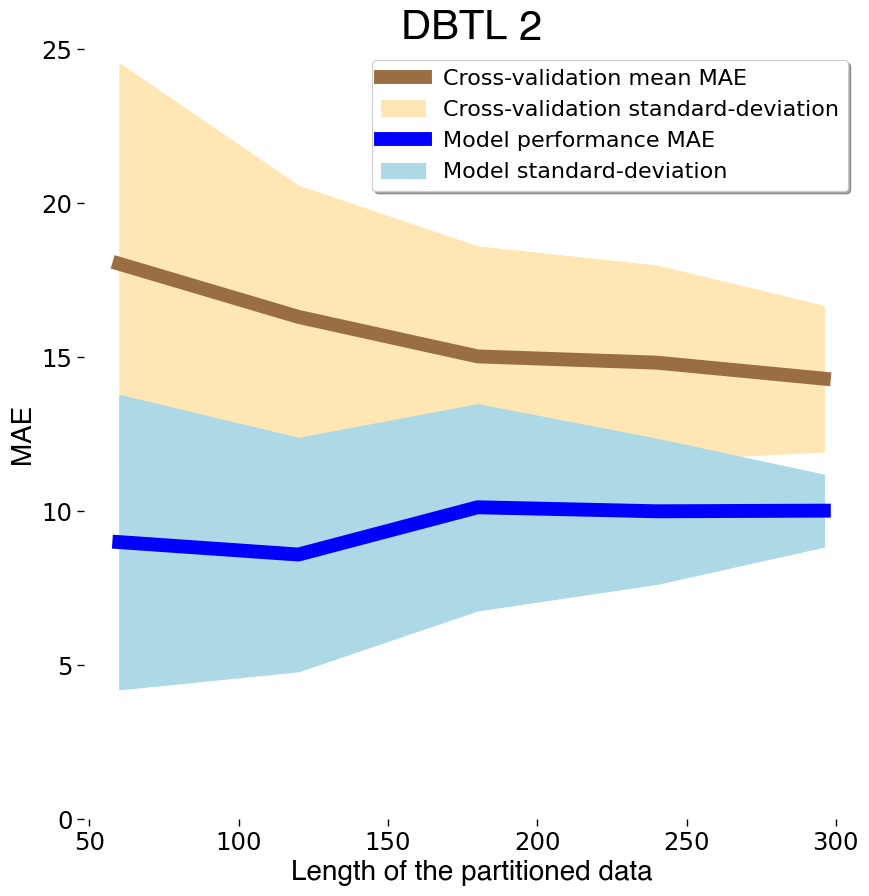

In [162]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  np.array(list(cross_validated_results_sd['mean']))

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))

plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , 
                              path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Learning_curve_on_partitioned_data_DBTL2_23_1002', 
                             size_height = 10,
                             size_length = 10, 
                             linewidth=10, 
                             title = 'DBTL 2'
)

In [163]:
#h2o.shutdown()